# Readme
This is the code has been **refactored** for easily readable, so it may look a little bit different compared to previous version (**Version 6** in Kaggle). This is the implementation of the **final architecture** proposed in the report, along with other feature extraction. To check previous version, including training and plot using in the report, please check out older version.

For convenient find these keywords to check module:
- FEATURE ENMO
- FEATURE LIGHT
- Statistic features
- CNN
- DROPOUT
- SIGMOID
- L2 regularization

# Import

In [1]:
# data analysis
import pandas as pd
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#other
import os
from tqdm import tqdm

# Final function to use:

In [2]:
#no need because all parquet ids have the output sii. Checked.
def filter_na(tabular, dirname):
    tabular = tabular.dropna(subset='sii')
    ids = tabular['id']
    par_ids = os.listdir(dirname)
    par_ids = [item.replace('id=', '') for item in par_ids]
    par_ids = pd.Series(par_ids, name='id')
    temp = len(par_ids)
    print(temp)
    par_ids = par_ids[par_ids.isin(ids)]
    print(len(par_ids))
    print(par_ids.isin(ids).all())

def extract_enmo(df_source, id=None):
    df = df_source.copy()
    df = df[df['non-wear_flag'] == 0]
    df.drop('non-wear_flag', axis=1, inplace=True)
    df.loc[:, 'Type_activity'] = 'Non-assigned'
    df.loc[(df['enmo'] < 10*1e-3), 'Type_activity'] = 'sedentary'
    df.loc[(df['enmo'] >= 10*1e-3) & (df['enmo'] < 100*1e-3), 'Type_activity'] = 'light'
    df.loc[(df['enmo'] >= 100*1e-3), 'Type_activity'] = 'moderate'
    
    total_wear = df['step'].count()
    
    sedentary_perall = df[df['Type_activity'] == 'sedentary']['step'].count()
    sedentary_perall = sedentary_perall / total_wear
    
    light_perall = df[df['Type_activity'] == 'light']['step'].count()
    light_perall = light_perall / total_wear
    
    moderate_perall = df[df['Type_activity'] == 'moderate']['step'].count()
    moderate_perall = moderate_perall / total_wear

    sedentary_perall, light_perall, moderate_perall
    return pd.DataFrame({'id': [id], 
                         'sedentary_por': [sedentary_perall], 
                         'light_por': [light_perall],
                         'moderate_por': [moderate_perall]}
                       )

    
def extract_light(df_source, id=None):
    df = df_source.copy()
    df = df[df['non-wear_flag'] == 0]
    df.drop('non-wear_flag', axis=1, inplace=True)
    df.loc[:, 'Type_light'] = 'Non-assigned'
    df.loc[(df['light'] < 25), 'Type_light'] = 'dark'
    df.loc[(df['light'] >= 25) & (df['light'] < 100), 'Type_light'] = 'normal'
    df.loc[(df['light'] >= 100), 'Type_light'] = 'bright'
    
    total_wear = df['step'].count()
    
    dark_perall = df[df['Type_light'] == 'dark']['step'].count()
    dark_perall = dark_perall / total_wear
    
    normal_perall = df[df['Type_light'] == 'normal']['step'].count()
    normal_perall = normal_perall / total_wear
    
    bright_perall = df[df['Type_light'] == 'bright']['step'].count()
    bright_perall = bright_perall / total_wear
    
    dark_perall, normal_perall, bright_perall
    return pd.DataFrame({'id': [id], 
                         'dark_por': [dark_perall], 
                         'normal_por': [normal_perall],
                         'bright_por': [bright_perall]}
                       )


# TEST: FEATURE ENMO

100%|██████████| 996/996 [02:20<00:00,  7.11it/s]


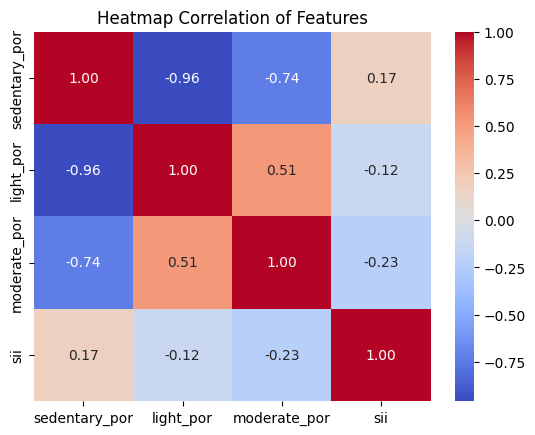

In [3]:
# STATUS: Done 
listdir = os.listdir("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
res_df = None
for dir in tqdm(listdir):
    # print(dir)
    dft = pd.read_parquet(os.path.join("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet", dir, "part-0.parquet"))
    
    id = dir[3:]
    # Extract each id
    ex_df = extract_enmo(dft, id=id)
    if res_df is None:
        res_df = ex_df
    else:
        res_df = pd.concat([res_df, ex_df])


import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
time_series = res_df
selected = train[['id', 'sii']]
time_series = time_series.merge(selected, on='id', how='left')


correlation = time_series.drop(columns = 'id').corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Correlation of Features")
plt.show()

# TEST: FEATURE LIGHT

100%|██████████| 996/996 [01:32<00:00, 10.73it/s]


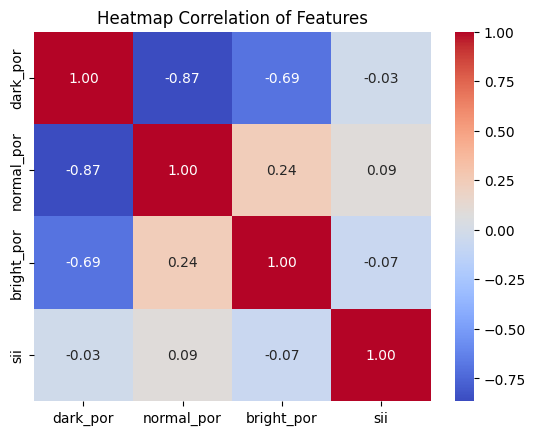

In [4]:
#STATUS: Done 
listdir = os.listdir("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
res_df = None
for dir in tqdm(listdir):
    # print(dir)
    dft = pd.read_parquet(os.path.join("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet", dir, "part-0.parquet"))
    
    id = dir[3:]
    # Extract each id
    ex_df = extract_light(dft, id=id)
    if res_df is None:
        res_df = ex_df
    else:
        res_df = pd.concat([res_df, ex_df])


res_df.reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
time_series = res_df
selected = train[['id', 'sii']]
time_series = time_series.merge(selected, on='id', how='left')
time_series.head()

correlation = time_series.drop(columns = 'id').corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Correlation of Features")
plt.show()

# Statistic features

In [5]:
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


In [6]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]


def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


In [7]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts  = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


In [8]:
train_ts

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,b2987a65
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,7b8842c3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,...,3.669502,89.025551,1.0,2576.399902,4191.0,8.639500e+13,7.0,4.0,161.0,cd68643b
992,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,...,1.786410,81.665283,0.0,1526.599976,4194.0,8.514000e+13,7.0,2.0,130.0,f8ff0bc8
993,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,...,3.692727,89.333710,1.0,2592.199951,4178.0,8.639500e+13,7.0,1.0,79.0,db23fbe4
994,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,...,1.673958,88.629547,0.0,1875.199951,4183.0,8.639500e+13,7.0,1.0,155.0,687c85e7


# Using CNN to extract feature

In [3]:
# data analysis
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import functional as F
#other
import os
from tqdm import tqdm

## Architecture

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cur_epoch = 0
        #input (N, 5)
        self.conv1 = nn.Conv1d(5, 64, kernel_size=3, stride=2, padding='valid') # 32, N, 1
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding='valid') # 32, N, 1
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding='valid') # 32, N, 1
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding='valid') # 32, N, 1
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv1d(256, 256, kernel_size=3, stride=2, padding='valid')
        
        self.fc1 = nn.Linear(256, 128) # Adjust output size based on input dims
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

        self.dropout1 = nn.Dropout(0.3, inplace=False)
        self.dropout2 = nn.Dropout(0.3, inplace=False)

        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, debug=False):
        x = self.leaky_relu(self.conv1(x))
        if debug: print(x.shape)
        x = self.maxpool1(x)
        if debug: print(x.shape)

        x = self.leaky_relu(self.conv2(x))
        if debug: print(x.shape)
        x = self.maxpool2(x)
        if debug: print(x.shape)

        x = self.leaky_relu(self.conv3(x))
        if debug: print(x.shape)
        x = self.maxpool3(x)
        if debug: print(x.shape)

        x = self.leaky_relu(self.conv4(x))
        if debug: print(x.shape)
        x = self.maxpool4(x)
        if debug: print(x.shape)

        x = self.leaky_relu(self.conv5(x))
        if debug: print(x.shape)

        x = F.adaptive_avg_pool1d(x, 1).squeeze() # GlOBAL POOLING
        if debug: print(x.shape)

        x = self.sigmoid(self.fc1(x))
        if debug: print(x.shape)
        x = self.dropout1(x) # DROPOUT
        
        x = self.sigmoid(self.fc2(x)) #SIGMOID , act1 is sigmoid, act is LeakyReLU.
        x = self.dropout2(x) # DROPOUT
        
        x = self.fc3(x)
        if debug: print(x.shape)
        x = F.softmax(x, dim=0)

        return x


#TEST: DONE
# model = CNN()
# input = torch.rand(5, 853)
# output = model(input, True)
# print(output)

## Training set and validation set

In [5]:
def split_train_test(ids, test_size=0.2, random_state=24):
    """Splits IDs into train and test sets."""
    train_ids, val_ids = train_test_split(ids, test_size=test_size, random_state=random_state)
    return train_ids, val_ids

class Dataset:
    def __init__(self, device, path_tabu, path_ts, preload=True, type='train', random_state=24):
        self.device = device
        self.path_ts = path_ts
        self.tabu_data = pd.read_csv(path_tabu) 
        self.ids = [x[3:] for x in os.listdir(path_ts)]
        self.filter()
        self.ids.sort()

        # Split into train and val sets
        train_ids, val_ids = split_train_test(self.ids, test_size=0.2, random_state=random_state)

        # Assign IDs based on type
        self.type = type
        if type == 'train':
            self.ids = train_ids
        elif type == 'val':
            self.ids = val_ids

        self.preload = preload
        if self.preload:
            self.ts_data_X, self.ts_data_Y = self.load_all_data()
    
    def filter(self):
        temp_ids = []
        for id in tqdm(self.ids):
            df = pd.read_parquet(os.path.join(self.path_ts, "id=" + id, "part-0.parquet"))
            if df.shape[0] >= 900:
                temp_ids.append(id)
        self.ids = temp_ids

    def collate(self, index):
        X = [self.ts_data_X[i].to(self.device) for i in index]
        Y = None
        if self.ts_data_Y is not None:
            Y = [self.ts_data_Y[i] for i in index]
            Y = torch.tensor(Y, dtype=torch.int64)
            Y = torch.nn.functional.one_hot(Y, num_classes=4).to(self.device).to(torch.float32)
        return {'X': X,
                'Y': Y}
            
    def dataloader(self, batch_size=1):
        size = len(self.ts_data_X)
        batch_size = size if batch_size == -1 else batch_size
        loader = DataLoader(list(range(size)), batch_size=batch_size, collate_fn=self.collate, shuffle=True if self.type == 'test' else False, num_workers=0)
        return loader
        
    def load_all_data(self):
        count = 0
        inputs = []
        labels = None if self.type == 'test' else list()
        for id in tqdm(self.ids):
            df = pd.read_parquet(os.path.join(self.path_ts, "id=" + id, "part-0.parquet"))
            df = df.loc[:, ['X', 'Y', 'Z', 'enmo', 'anglez']]
            # normalize the signals 
            scaler = StandardScaler()
            df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            input = torch.tensor(df.values)
            input = input.T
            inputs.append(input)
            if self.type != 'test': labels.append(self.tabu_data[self.tabu_data['id'] == id]['sii'].values[0])
        return inputs, labels
    
        

## Trainer

In [6]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn=F.binary_cross_entropy):
        self.optim = optimizer
        self.model = model
        self.cur_epoch = model.cur_epoch
        self.loss_fn = loss_fn

    def train_one_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0.0
        
        with tqdm(dataloader, desc="Training", unit="batch") as pbar:
            for data in pbar:
                X = data['X']
                Y = data['Y']

                self.optim.zero_grad()

                outs = []
                for x in X:
                    outs.append(self.model(x))
                outs = torch.stack(outs, dim=0)

                loss = self.loss_fn(outs, Y)
                loss.backward()
                self.optim.step()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
        
        # Return the average loss for this epoch
        return epoch_loss / len(dataloader)
    def evaluate(self, valloader):
        model.eval()
        for data in valloader:
            X = data['X']
            Y = data['Y']

            outs = []
            with torch.no_grad():
                for x in X:
                    outs.append(self.model(x))
                outs = torch.stack(outs, dim=0)
                loss = nn.functional.binary_cross_entropy(outs, Y).item()
                outs = torch.argmax(outs, dim=-1)
                Y = torch.argmax(Y, dim=-1)
                outs = outs.cpu().detach().numpy()
                Y = Y.cpu().detach().numpy()
            return accuracy_score(Y, outs), loss
            
            
                
    def train(self, trainloader, max_epoch, validloader=None):
        tracking_train = []
        tracking_val = []
        tracking_val_BCE = []
        self.cur_epoch = self.model.cur_epoch
        for epoch in range(self.cur_epoch + 1, max_epoch + 1):
            print(f"Epoch {epoch}/{max_epoch}")
            
            # Train for one epoch and log the loss
            train_loss = self.train_one_epoch(trainloader)
            tracking_train.append( (epoch, train_loss) )
            print(f"Epoch {epoch} Training Loss: {train_loss:.4f}")

            if epoch % 5 == 0:
                print("Valid:")
                accuracy, BCE_loss = self.evaluate(validloader)
                print(f"Epoch {epoch} Accuracy: {accuracy:.6f} BCE_loss: {BCE_loss:.6f}")
                tracking_val.append( (epoch, accuracy) )
                tracking_val_BCE.append( (epoch, BCE_loss))
            if epoch % 5 == 0:
                torch.save(model.state_dict(), f"model-{epoch}.pth")
            self.model.cur_epoch = epoch
            
        self.cur_epoch = max_epoch
        return tracking_train, tracking_val, tracking_val_BCE


In [7]:
#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_tabu_path="/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
train_ts_path='/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'

trainset = Dataset(device, path_tabu=train_tabu_path, path_ts=train_ts_path, type='train')
trainloader = trainset.dataloader(batch_size=40)

valset = Dataset(device, path_tabu=train_tabu_path, path_ts=train_ts_path, type='val')
valloader = valset.dataloader(batch_size=-1)

100%|██████████| 200/200 [00:08<00:00, 22.40it/s]


In [8]:
model = CNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
trainer = Trainer(model, optimizer)
tracking_train, tracking_val, tracking_val_BCE = trainer.train(trainloader, 120, valloader)

Epoch 1/120


Training: 100%|██████████| 20/20 [00:11<00:00,  1.78batch/s, loss=0.409]


Epoch 1 Training Loss: 0.4553
Epoch 2/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.386]


Epoch 2 Training Loss: 0.4349
Epoch 3/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.17batch/s, loss=0.415]


Epoch 3 Training Loss: 0.4321
Epoch 4/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.406]


Epoch 4 Training Loss: 0.4322
Epoch 5/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.402]


Epoch 5 Training Loss: 0.4327
Valid:
Epoch 5 Accuracy: 0.570000 BCE_loss: 0.434441
Epoch 6/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.405]


Epoch 6 Training Loss: 0.4337
Epoch 7/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.09batch/s, loss=0.384]


Epoch 7 Training Loss: 0.4322
Epoch 8/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.388]


Epoch 8 Training Loss: 0.4287
Epoch 9/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.05batch/s, loss=0.388]


Epoch 9 Training Loss: 0.4296
Epoch 10/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.376]


Epoch 10 Training Loss: 0.4330
Valid:
Epoch 10 Accuracy: 0.570000 BCE_loss: 0.433686
Epoch 11/120


Training: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, loss=0.391]


Epoch 11 Training Loss: 0.4315
Epoch 12/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.98batch/s, loss=0.399]


Epoch 12 Training Loss: 0.4279
Epoch 13/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.95batch/s, loss=0.389]


Epoch 13 Training Loss: 0.4292
Epoch 14/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.381]


Epoch 14 Training Loss: 0.4268
Epoch 15/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.90batch/s, loss=0.373]


Epoch 15 Training Loss: 0.4255
Valid:
Epoch 15 Accuracy: 0.570000 BCE_loss: 0.424245
Epoch 16/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.89batch/s, loss=0.379]


Epoch 16 Training Loss: 0.4233
Epoch 17/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.377]


Epoch 17 Training Loss: 0.4216
Epoch 18/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.95batch/s, loss=0.381]


Epoch 18 Training Loss: 0.4215
Epoch 19/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.95batch/s, loss=0.377]


Epoch 19 Training Loss: 0.4195
Epoch 20/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.95batch/s, loss=0.378]


Epoch 20 Training Loss: 0.4198
Valid:
Epoch 20 Accuracy: 0.570000 BCE_loss: 0.418433
Epoch 21/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.363]


Epoch 21 Training Loss: 0.4168
Epoch 22/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.354]


Epoch 22 Training Loss: 0.4166
Epoch 23/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.363]


Epoch 23 Training Loss: 0.4206
Epoch 24/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.374]


Epoch 24 Training Loss: 0.4217
Epoch 25/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.372]


Epoch 25 Training Loss: 0.4201
Valid:
Epoch 25 Accuracy: 0.570000 BCE_loss: 0.420393
Epoch 26/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.367]


Epoch 26 Training Loss: 0.4209
Epoch 27/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.364]


Epoch 27 Training Loss: 0.4196
Epoch 28/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.373]


Epoch 28 Training Loss: 0.4180
Epoch 29/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.371]


Epoch 29 Training Loss: 0.4161
Epoch 30/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.369]


Epoch 30 Training Loss: 0.4153
Valid:
Epoch 30 Accuracy: 0.570000 BCE_loss: 0.417755
Epoch 31/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.38] 


Epoch 31 Training Loss: 0.4206
Epoch 32/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.361]


Epoch 32 Training Loss: 0.4180
Epoch 33/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.352]


Epoch 33 Training Loss: 0.4126
Epoch 34/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.36] 


Epoch 34 Training Loss: 0.4109
Epoch 35/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.385]


Epoch 35 Training Loss: 0.4181
Valid:
Epoch 35 Accuracy: 0.570000 BCE_loss: 0.419936
Epoch 36/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.369]


Epoch 36 Training Loss: 0.4212
Epoch 37/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.352]


Epoch 37 Training Loss: 0.4132
Epoch 38/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.37] 


Epoch 38 Training Loss: 0.4140
Epoch 39/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.372]


Epoch 39 Training Loss: 0.4143
Epoch 40/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.369]


Epoch 40 Training Loss: 0.4160
Valid:
Epoch 40 Accuracy: 0.565000 BCE_loss: 0.428351
Epoch 41/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.358]


Epoch 41 Training Loss: 0.4116
Epoch 42/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.361]


Epoch 42 Training Loss: 0.4126
Epoch 43/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.365]


Epoch 43 Training Loss: 0.4149
Epoch 44/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.368]


Epoch 44 Training Loss: 0.4142
Epoch 45/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.353]


Epoch 45 Training Loss: 0.4113
Valid:
Epoch 45 Accuracy: 0.560000 BCE_loss: 0.421186
Epoch 46/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.364]


Epoch 46 Training Loss: 0.4096
Epoch 47/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.349]


Epoch 47 Training Loss: 0.4096
Epoch 48/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.36] 


Epoch 48 Training Loss: 0.4095
Epoch 49/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.361]


Epoch 49 Training Loss: 0.4132
Epoch 50/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.371]


Epoch 50 Training Loss: 0.4114
Valid:
Epoch 50 Accuracy: 0.565000 BCE_loss: 0.418485
Epoch 51/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.355]


Epoch 51 Training Loss: 0.4109
Epoch 52/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.353]


Epoch 52 Training Loss: 0.4116
Epoch 53/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.357]


Epoch 53 Training Loss: 0.4084
Epoch 54/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.358]


Epoch 54 Training Loss: 0.4098
Epoch 55/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.35] 


Epoch 55 Training Loss: 0.4062
Valid:
Epoch 55 Accuracy: 0.565000 BCE_loss: 0.420617
Epoch 56/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.353]


Epoch 56 Training Loss: 0.4063
Epoch 57/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.348]


Epoch 57 Training Loss: 0.4045
Epoch 58/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.357]


Epoch 58 Training Loss: 0.4062
Epoch 59/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.356]


Epoch 59 Training Loss: 0.4062
Epoch 60/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.356]


Epoch 60 Training Loss: 0.4071
Valid:
Epoch 60 Accuracy: 0.560000 BCE_loss: 0.422264
Epoch 61/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.349]


Epoch 61 Training Loss: 0.4053
Epoch 62/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.343]


Epoch 62 Training Loss: 0.4090
Epoch 63/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.359]


Epoch 63 Training Loss: 0.4147
Epoch 64/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.378]


Epoch 64 Training Loss: 0.4108
Epoch 65/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.356]


Epoch 65 Training Loss: 0.4072
Valid:
Epoch 65 Accuracy: 0.565000 BCE_loss: 0.421044
Epoch 66/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.351]


Epoch 66 Training Loss: 0.4140
Epoch 67/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.363]


Epoch 67 Training Loss: 0.4076
Epoch 68/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.376]


Epoch 68 Training Loss: 0.4091
Epoch 69/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.36] 


Epoch 69 Training Loss: 0.4057
Epoch 70/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.358]


Epoch 70 Training Loss: 0.4050
Valid:
Epoch 70 Accuracy: 0.545000 BCE_loss: 0.420957
Epoch 71/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.356]


Epoch 71 Training Loss: 0.4043
Epoch 72/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.349]


Epoch 72 Training Loss: 0.4027
Epoch 73/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.346]


Epoch 73 Training Loss: 0.4016
Epoch 74/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.344]


Epoch 74 Training Loss: 0.3964
Epoch 75/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.343]


Epoch 75 Training Loss: 0.3955
Valid:
Epoch 75 Accuracy: 0.540000 BCE_loss: 0.429469
Epoch 76/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.339]


Epoch 76 Training Loss: 0.3957
Epoch 77/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.341]


Epoch 77 Training Loss: 0.3955
Epoch 78/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.338]


Epoch 78 Training Loss: 0.3987
Epoch 79/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.348]


Epoch 79 Training Loss: 0.4003
Epoch 80/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.328]


Epoch 80 Training Loss: 0.3918
Valid:
Epoch 80 Accuracy: 0.550000 BCE_loss: 0.426728
Epoch 81/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.32] 


Epoch 81 Training Loss: 0.3870
Epoch 82/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.35] 


Epoch 82 Training Loss: 0.3884
Epoch 83/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.331]


Epoch 83 Training Loss: 0.3860
Epoch 84/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.329]


Epoch 84 Training Loss: 0.3829
Epoch 85/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.309]


Epoch 85 Training Loss: 0.3818
Valid:
Epoch 85 Accuracy: 0.530000 BCE_loss: 0.447204
Epoch 86/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.312]


Epoch 86 Training Loss: 0.3776
Epoch 87/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.365]


Epoch 87 Training Loss: 0.4003
Epoch 88/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.326]


Epoch 88 Training Loss: 0.3851
Epoch 89/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.298]


Epoch 89 Training Loss: 0.3797
Epoch 90/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.328]


Epoch 90 Training Loss: 0.3739
Valid:
Epoch 90 Accuracy: 0.555000 BCE_loss: 0.455235
Epoch 91/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.291]


Epoch 91 Training Loss: 0.3659
Epoch 92/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.275]


Epoch 92 Training Loss: 0.3603
Epoch 93/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.272]


Epoch 93 Training Loss: 0.3629
Epoch 94/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.267]


Epoch 94 Training Loss: 0.3546
Epoch 95/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.29] 


Epoch 95 Training Loss: 0.3551
Valid:
Epoch 95 Accuracy: 0.540000 BCE_loss: 0.474504
Epoch 96/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.268]


Epoch 96 Training Loss: 0.3552
Epoch 97/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.265]


Epoch 97 Training Loss: 0.3492
Epoch 98/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.3]  


Epoch 98 Training Loss: 0.3617
Epoch 99/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.261]


Epoch 99 Training Loss: 0.3391
Epoch 100/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.257]


Epoch 100 Training Loss: 0.3451
Valid:
Epoch 100 Accuracy: 0.545000 BCE_loss: 0.485470
Epoch 101/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.309]


Epoch 101 Training Loss: 0.3497
Epoch 102/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.273]


Epoch 102 Training Loss: 0.3616
Epoch 103/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.252]


Epoch 103 Training Loss: 0.3341
Epoch 104/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.244]


Epoch 104 Training Loss: 0.3229
Epoch 105/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.241]


Epoch 105 Training Loss: 0.3298
Valid:
Epoch 105 Accuracy: 0.545000 BCE_loss: 0.535508
Epoch 106/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.228]


Epoch 106 Training Loss: 0.3139
Epoch 107/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.217]


Epoch 107 Training Loss: 0.3228
Epoch 108/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.236]


Epoch 108 Training Loss: 0.3116
Epoch 109/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.281]


Epoch 109 Training Loss: 0.3244
Epoch 110/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.36] 


Epoch 110 Training Loss: 0.3601
Valid:
Epoch 110 Accuracy: 0.525000 BCE_loss: 0.492173
Epoch 111/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.283]


Epoch 111 Training Loss: 0.3967
Epoch 112/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.394]


Epoch 112 Training Loss: 0.3674
Epoch 113/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.401]


Epoch 113 Training Loss: 0.3768
Epoch 114/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.29] 


Epoch 114 Training Loss: 0.3531
Epoch 115/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.254]


Epoch 115 Training Loss: 0.3734
Valid:
Epoch 115 Accuracy: 0.525000 BCE_loss: 0.467101
Epoch 116/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.267]


Epoch 116 Training Loss: 0.3719
Epoch 117/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.257]


Epoch 117 Training Loss: 0.3568
Epoch 118/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.243]


Epoch 118 Training Loss: 0.3389
Epoch 119/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.22] 


Epoch 119 Training Loss: 0.3073
Epoch 120/120


Training: 100%|██████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.205]


Epoch 120 Training Loss: 0.2958
Valid:
Epoch 120 Accuracy: 0.485000 BCE_loss: 0.523724


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization
trainer = Trainer(model, optimizer)
tracking_train1, tracking_val1, tracking_val_BCE1 = trainer.train(trainloader, 120, valloader)
tracking_train = tracking_train + tracking_train1
tracking_val = tracking_val + tracking_val1
tracking_val_BCE = tracking_val_BCE + tracking_val_BCE1

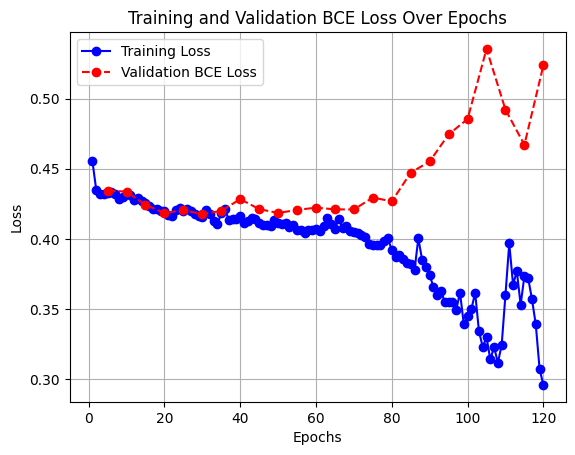

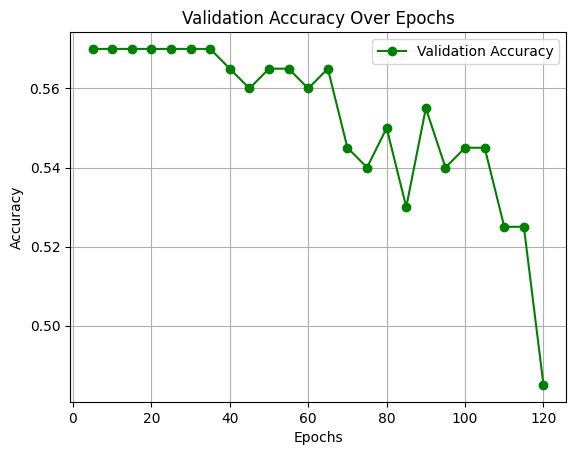

In [10]:
import matplotlib.pyplot as plt

def show_result(tracking_train, tracking_val, tracking_val_BCE):
    # Unpack data for training and validation
    epochs_train, train_losses = zip(*tracking_train)
    epochs_val_BCE, val_bce_losses = zip(*tracking_val_BCE)
    
    # Plot training loss and validation BCE loss in the same figure
    plt.plot(epochs_train, train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs_val_BCE, val_bce_losses, marker='o', linestyle='--', color='r', label='Validation BCE Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation BCE Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot validation accuracy separately
    epochs_val, accuracy = zip(*tracking_val)
    plt.plot(epochs_val, accuracy, marker='o', linestyle='-', color='g', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

show_result(tracking_train, tracking_val, tracking_val_BCE)
